## PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

In [45]:
what_were_building = {1: 'data (prepare and load)',
                      2: 'build model',
                      3: 'fitting the model to data (training)',
                      4: 'making preditctions and evaluating a model (inference)',
                      5: 'saving and loading a model',
                      6: 'putting it all together'}
what_were_building

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making preditctions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [46]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.2.1+cu121'

## 1. Data (Preparing and loading)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representations.
2. Build a model to learn patterns in the numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

we'll use a linear regression formula to make a straight line with *known* **parameters**.

In [47]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

print(X.shape)

X[:10], y[:10]

torch.Size([50, 1])


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [48]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create s training and test set with our data.

In [49]:
# create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [50]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize = (10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s = 4, label = "Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s = 4, label = "Testing data")

  # Are there predictions?
  if predictions is not None:
    # plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=  4, label = "Predictions")

  # show the legend
  plt.legend(prop={"size" : 14});

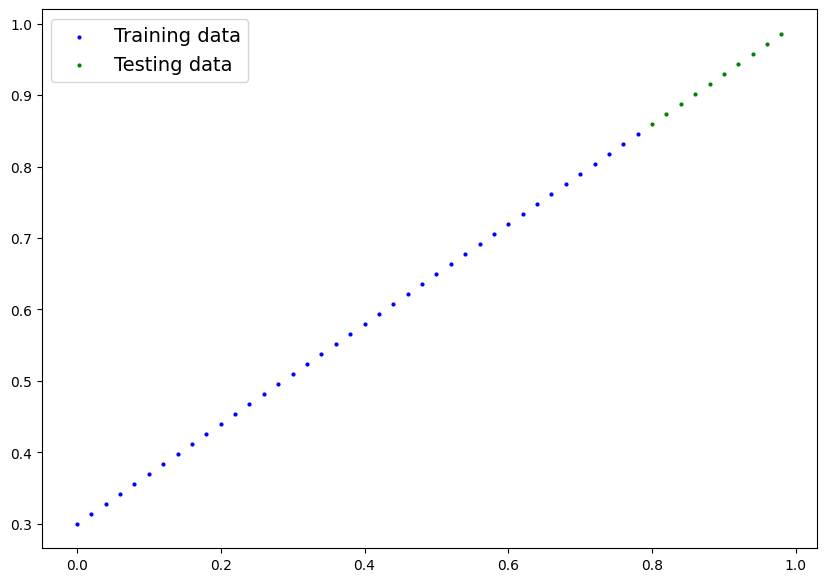

In [51]:
plot_predictions()

## 2. Building model

Our first PyTorch model!

This is very exciting...let's do it!

What our model does:
* Start with random values (weight and bias)
* Look at raining data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [52]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()

    # initialize model parameters
    # these could be:
    # 1. different layers from torch.nn
    # 2. single parameters
    # 3. hard-codded values
    # 4. functions
    self.weight = nn.Parameter(torch.randn(1, # <- start with random weight and try to adjust it to the ideal weight
                                           requires_grad=True,  #  <- can this parameter be updated via gradient descent?
                                           dtype = torch.float))  # <- PyTorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1,  # <- start with random weight and try to adjust it to the ideal weight
                                          requires_grad = True, #  <- can this parameter be updated via gradient descent?
                                          dtype = torch.float)) # <- PyTorch loves the datatype torch.float32
  # Forward method to define the computation in the model
  # Any subclass of nn.Module needs to override "forward()"
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weight * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contrains all of ther buildings for computational graphs (a neural network can be considered a computational graph).
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward().
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.
* torch.utils.data.Dataset - represents a map between key (label) and sample (features) pairs of your data. such as images and their associated labels.
* torch.utils.data.DataLoader - creates a Python iterable over a torch Dataset (allows you to iterate over your data).

### Checking the content of our PyTorch model

Now we've created a model, let's see what's inside...
So we can check our model parameters or what's inside our model using `.parameters()`.

In [53]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [54]:
# List named paramaters
# check out our model's parameters (a parameter is a value that the model sets itsaelf)
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how it will predict `y_test` based on `X_test`.
When we pass data through our model, it's going to run it through the `forward()` method.

In [55]:
y_pred = model_0(X_test)
y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [56]:
# Make predictions with model
with torch.inference_mode():
  y_pred = model_0(X_test)

# you can do something similar with torch.no_grad(), however, torch.inference_mode() is preffered

# with torch.no_grad():
#   y_pred = model_0(X_test)

y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

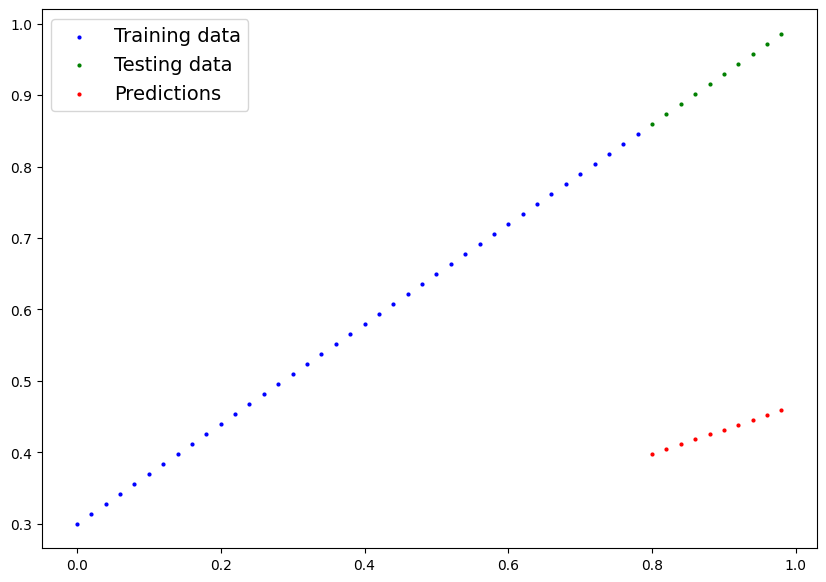

In [57]:
plot_predictions(predictions = y_pred )

### 3. Train model

The whole idea of training is for a model to move from some *unknown* parametrs (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:
* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters(e.g. weight & bias in our case) to improve the loss function.

  * Inside the optimizer you'll often have to set two parameters:
    * `params` - the model parameters you'd like to optimize for example `params = model_0.parameters()`
    * `lr` (learning rate) - the learning rate is a hyperparameter thet defines how big/small  the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [58]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                               lr = 0.01) # lr = learning rate = possibly the most important hyperparameter you can set

**Q:** Which loss function and optimizer should I use?

**A:** This will be problem specific. But with experience, you'll get an idea of what works and what does'nt with your particular problem set.

For example, for a regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying weather a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [59]:
torch.manual_seed(42)
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 100

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # traing mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Claculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f'Loss: {loss}')

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop
  # model_0.eval()  # turns off gradient tracking

  model_0.state_dict()

Loss: 0.31288138031959534
Loss: 0.3013603389263153
Loss: 0.28983935713768005
Loss: 0.2783183455467224
Loss: 0.26679736375808716
Loss: 0.2552763521671295
Loss: 0.24375534057617188
Loss: 0.23223432898521423
Loss: 0.22071333229541779
Loss: 0.20919232070446014
Loss: 0.1976713240146637
Loss: 0.18615034222602844
Loss: 0.1746293306350708
Loss: 0.16310831904411316
Loss: 0.1515873372554779
Loss: 0.14006635546684265
Loss: 0.1285453587770462
Loss: 0.11702437698841095
Loss: 0.1060912236571312
Loss: 0.09681284427642822
Loss: 0.08908725529909134
Loss: 0.08227583020925522
Loss: 0.07638873159885406
Loss: 0.07160007208585739
Loss: 0.06747635453939438
Loss: 0.06395438313484192
Loss: 0.06097004935145378
Loss: 0.05845819041132927
Loss: 0.05635259300470352
Loss: 0.0545857772231102
Loss: 0.053148526698350906
Loss: 0.05181945487856865
Loss: 0.05069301277399063
Loss: 0.0498228520154953
Loss: 0.04895269125699997
Loss: 0.04819351062178612
Loss: 0.047531817108392715
Loss: 0.04692792519927025
Loss: 0.046423316001

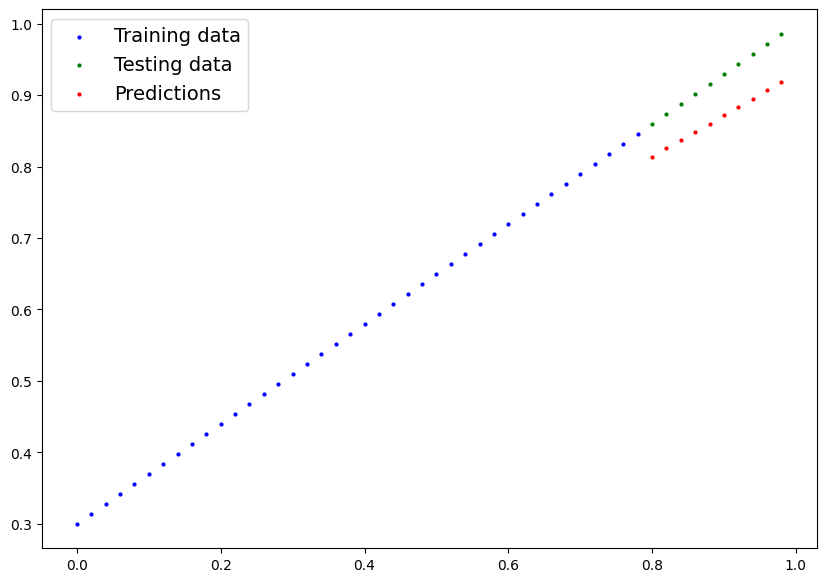

In [60]:
with torch.inference_mode():
  y_pred_new = model_0(X_test)
  plot_predictions(predictions = y_pred_new)